In [ ]:
#we load the necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import quantstats as qs

quarters = ['2023_Q1', '2023_Q3', '2023_Q4',
            '2024_Q2', '2024_Q4',
            '2025_Q1', '2025_Q2']
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller


: 

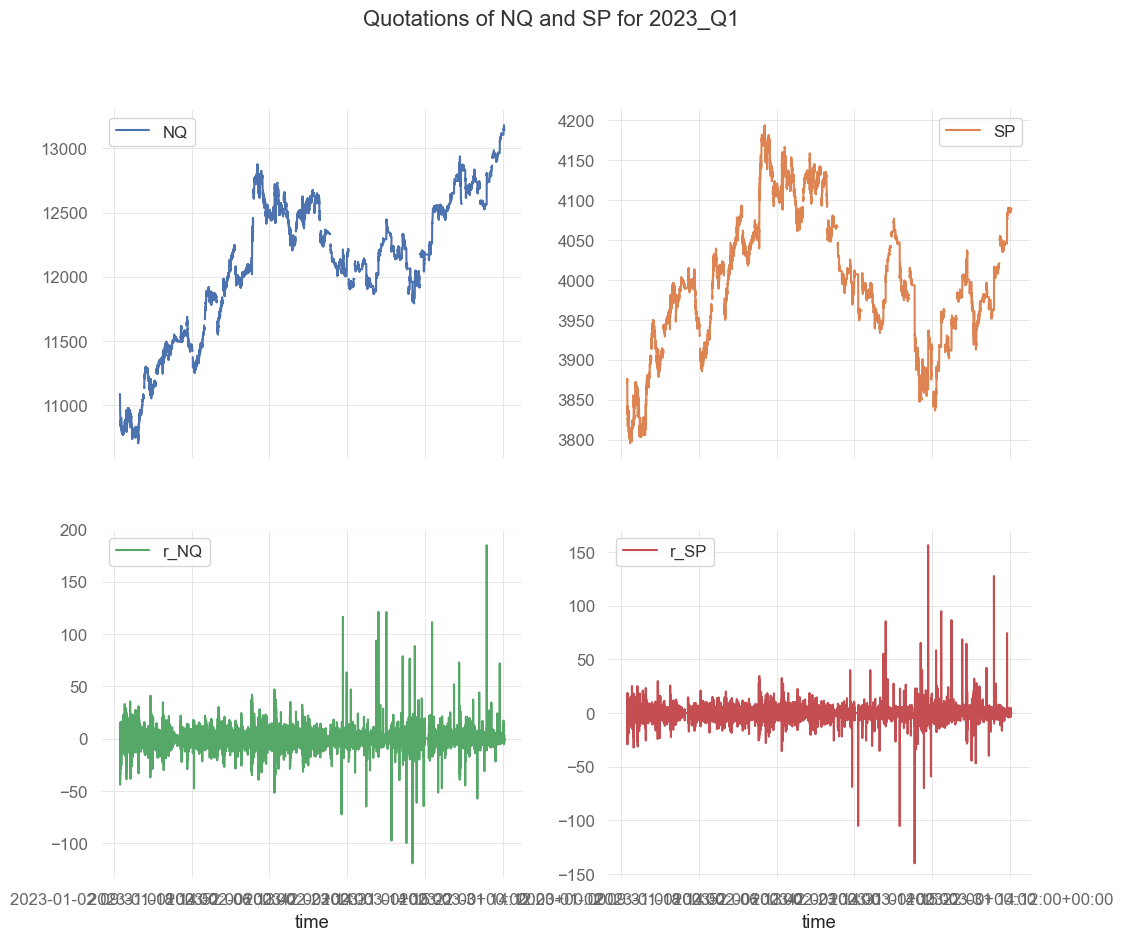

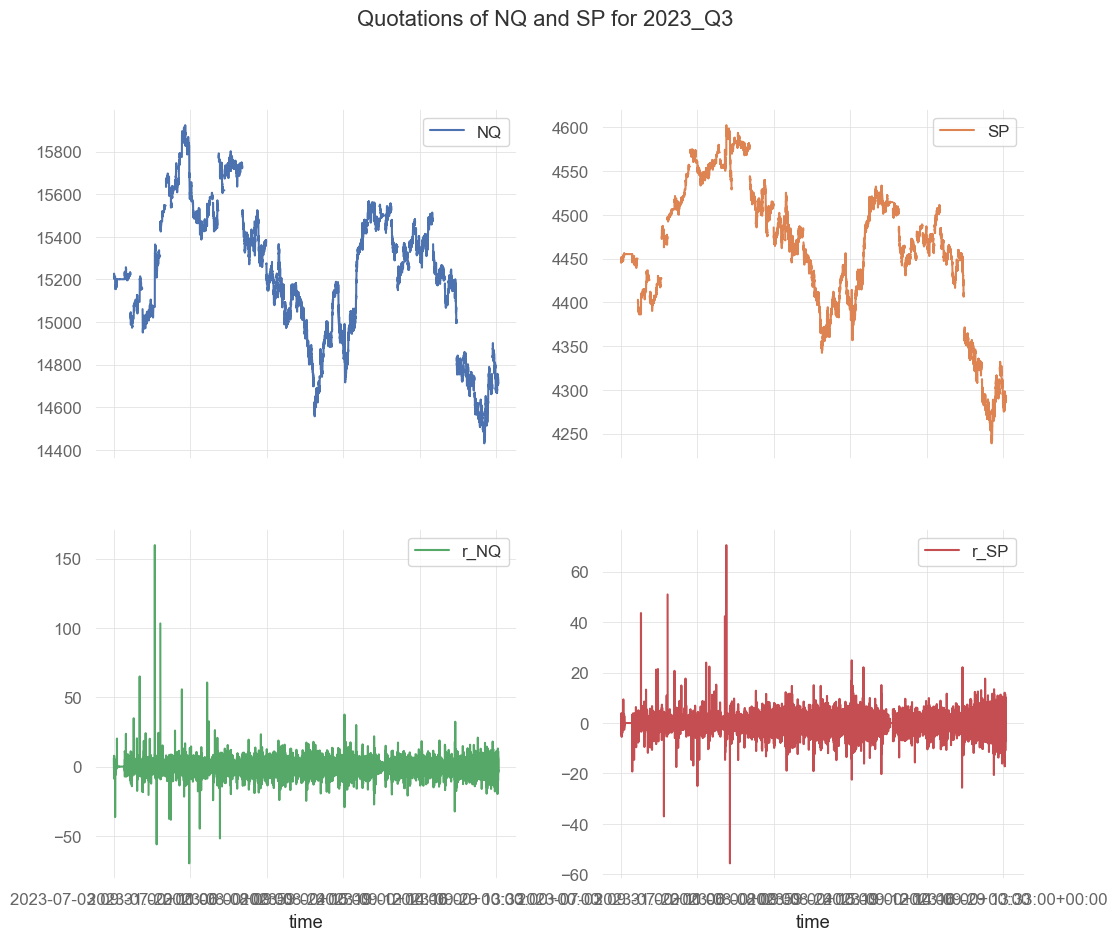

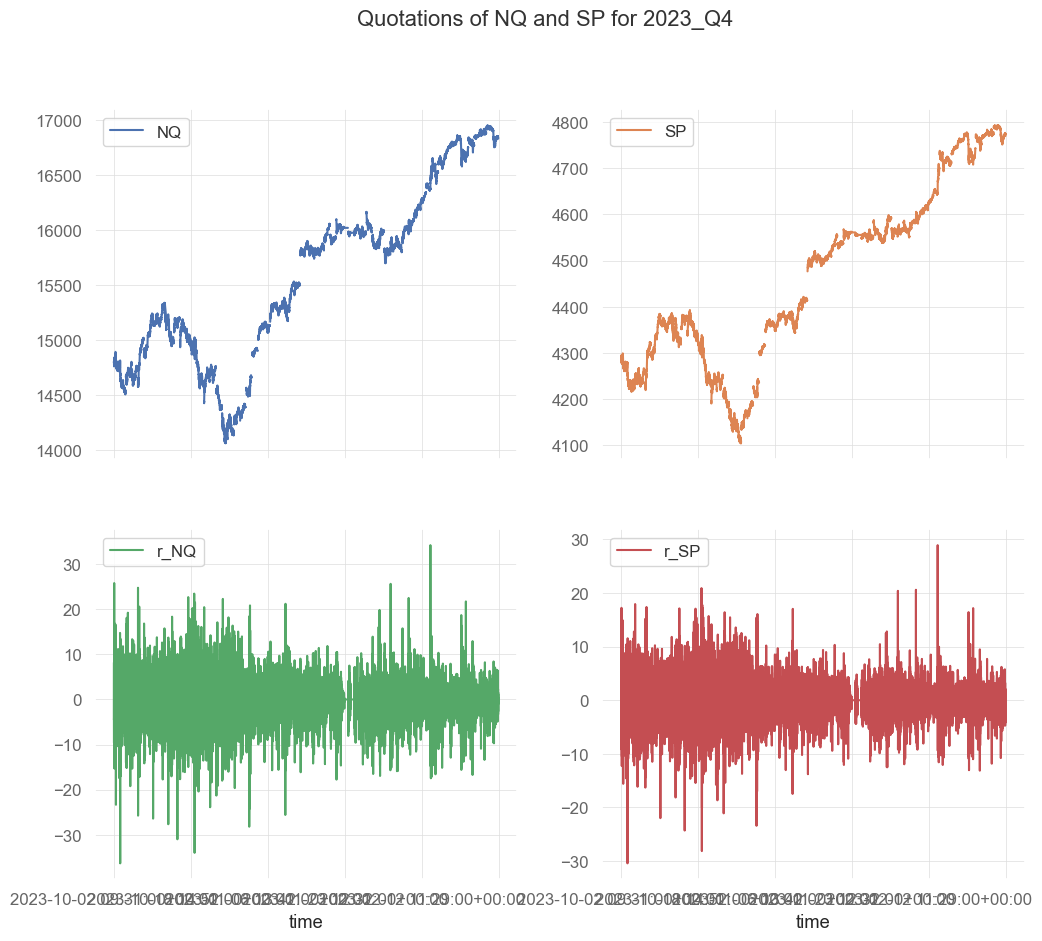

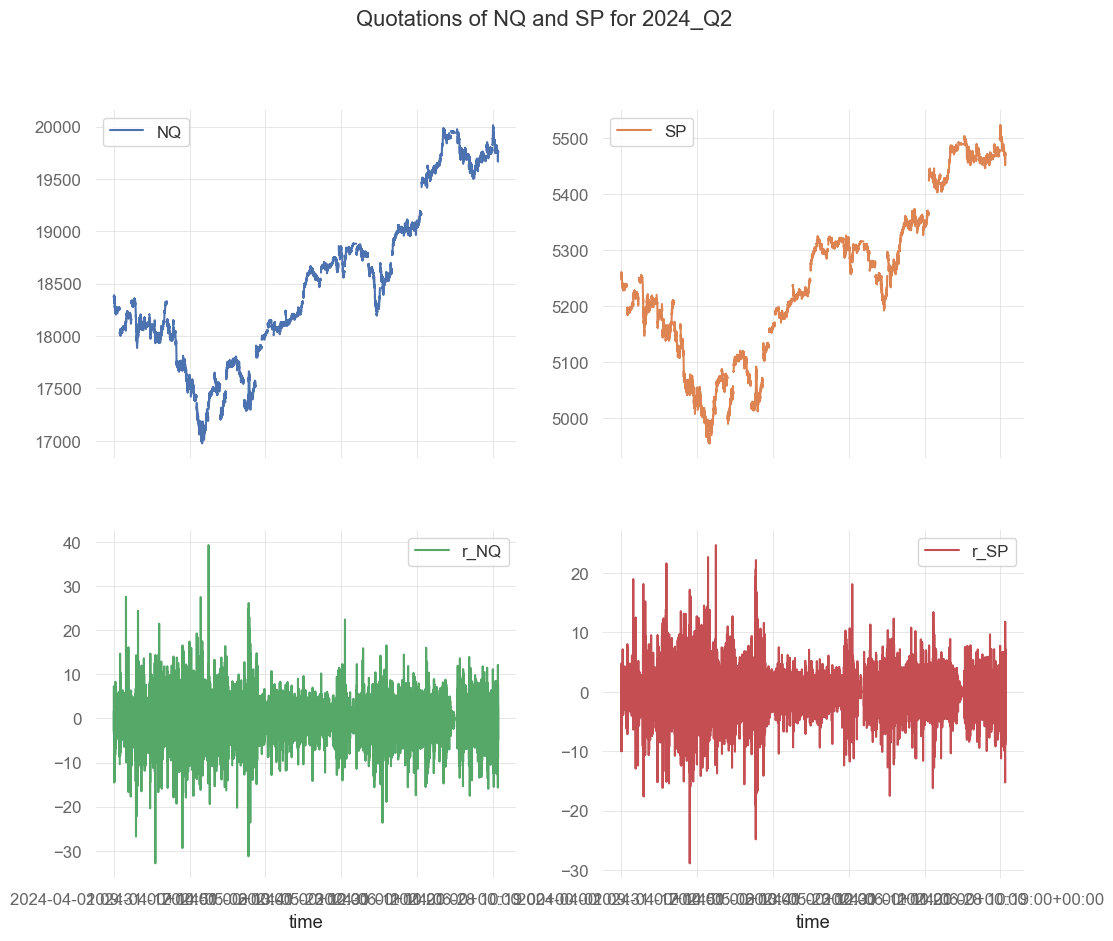

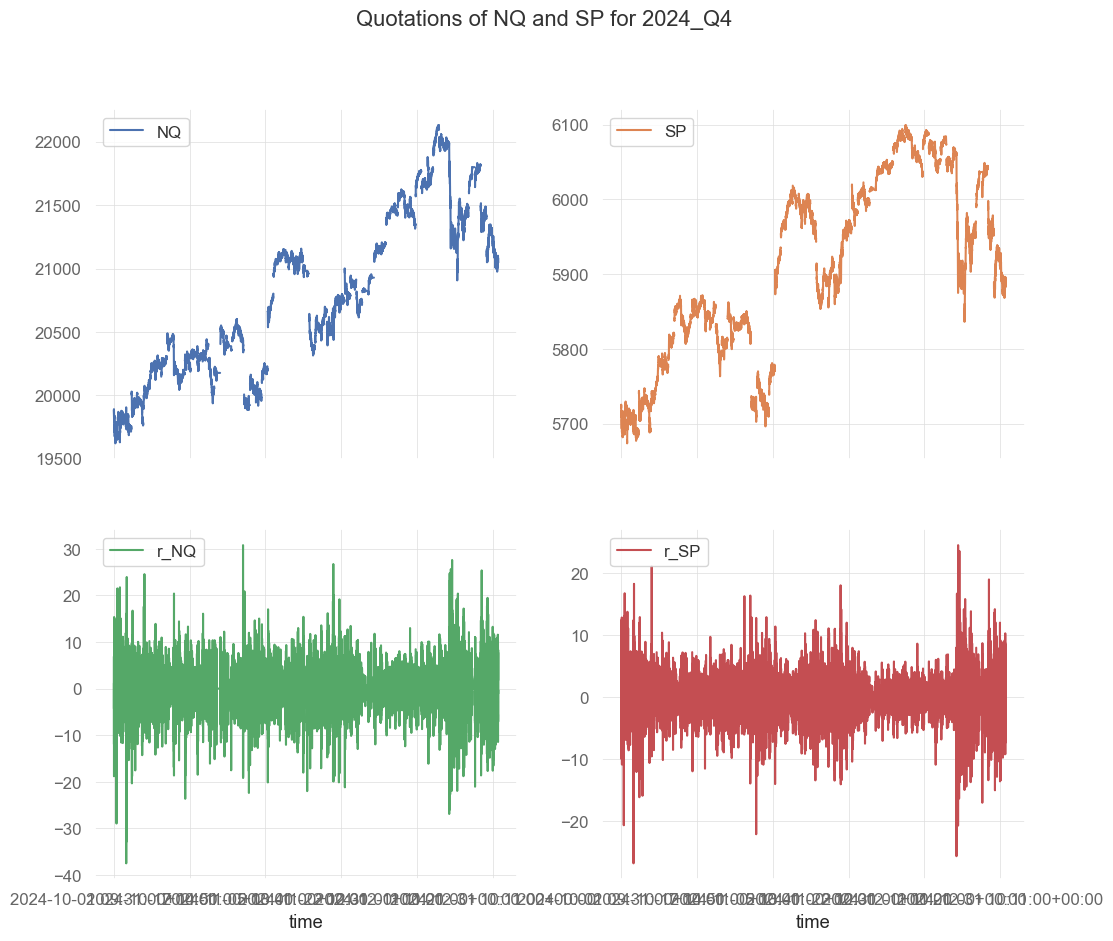

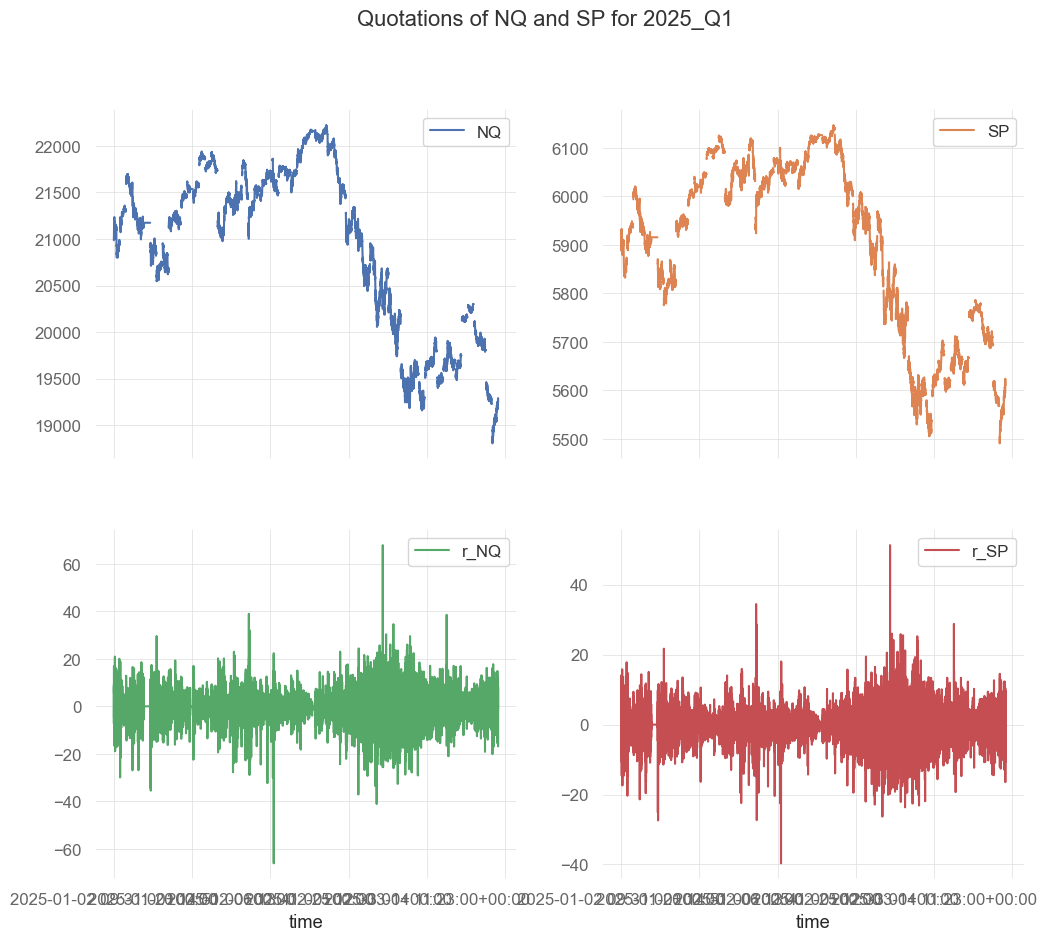

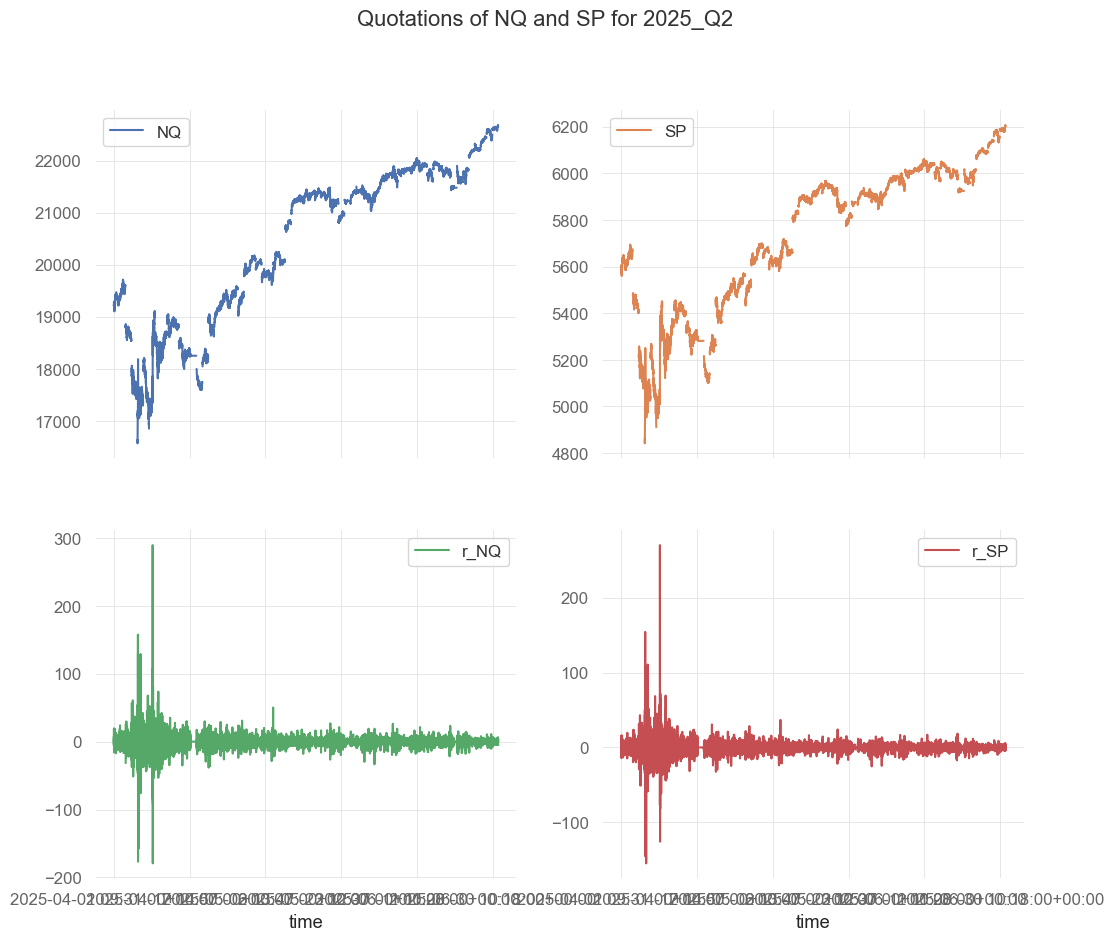

In [2]:
# Combine all quarterly data into one file with quarter identification
all_data_list = []

for quarter in quarters:
    data1 = pd.read_parquet(f'data/data1_{quarter}.parquet')
    data1['datetime'] = pd.to_datetime(data1['datetime'])
    data1.set_index('datetime', inplace=True)
    
    data_r = np.log(data1 / data1.shift(1)) * 10000
    data_r.columns = ['r_' + col for col in data_r.columns]
    
    data_NQ_SP_temp = pd.concat(
        [data1[['NQ', 'SP']],
        data_r[['r_NQ', 'r_SP']]],
        axis=1
    )
    
    data_NQ_SP_temp.loc[data_NQ_SP_temp.between_time("9:31", "9:40").index] = np.nan
    data_NQ_SP_temp.loc[data_NQ_SP_temp.between_time("15:51", "16:00").index] = np.nan
    
    data_NQ_SP_plot = data_NQ_SP_temp.copy()
    data_NQ_SP_plot['time'] = data_NQ_SP_plot.index.astype(str)

    # We reset the index to make 'time' a column
    data_NQ_SP_plot = data_NQ_SP_plot.reset_index(drop = True)

    # Let's set time as the X-axis and draw the graphs
    data_NQ_SP_plot.plot(
        x = 'time',
        subplots = True,
        layout = (2, 2),
        title = "Quotations of NQ and SP for" + f" {quarter}",
        figsize = (12, 10)
    )
    plt.show()
    
    # Add quarter column
    data_NQ_SP_temp['quarter'] = quarter
    
    all_data_list.append(data_NQ_SP_temp)

# Combine all data
all_data = pd.concat(all_data_list, axis=0)


In [ ]:
pos_flat = np.zeros(len(E6))

In [ ]:
# we check various parameter combinations in a loop

def mySR(x, scale):
    return np.sqrt(scale) * np.nanmean(x) / np.nanstd(x)

fastEMA_parameters = [15, 20, 30, 45, 60, 75, 90]
slowEMA_parameters = [90, 120, 150, 180, 240, 300, 360, 420]

# create a dataframe to store results
summary_all_2MAs = pd.DataFrame()

# Loop over each quarter
for quarter in quarters:
    print(f"\nProcessing quarter: {quarter}")
    
    # Filter data for the current quarter
    quarter_mask = all_data_2['quarter'] == quarter
    quarter_data = all_data_2[quarter_mask].copy()
    
    # Loop over different parameter combinations
    for fastEMA in fastEMA_parameters:
        for slowEMA in slowEMA_parameters:
                    
                    # ensure that fastEMA is less than slowEMA
                    if fastEMA >= slowEMA:
                        continue

                    print(f"  fastEMA = {fastEMA}, slowEMA = {slowEMA}")

                    # We calculate the appropriate EMA
                    fastEMA_values = quarter_data['spread_avratio'].ewm(span = fastEMA).mean()
                    slowEMA_values = quarter_data['spread_avratio'].ewm(span = slowEMA).mean()

                    # Insert NaNs wherever the original price is missing
                    fastEMA_values[quarter_data['spread_avratio'].isna()] = np.nan
                    slowEMA_values[quarter_data['spread_avratio'].isna()] = np.nan 

                    # Calculate position for momentum strategy
                    cond2b_mom_long = fastEMA_values.shift(1) > slowEMA_values.shift(1)
                    
                    # let's add filters that check for the presence of NaN values
                    fastEMA_nonmiss = fastEMA_values.shift(1).notna()
                    slowEMA_nonmiss = slowEMA_values.shift(1).notna()

                    # Now we can add these conditions to our strategies
                    # if any of the values is missing,
                    # we cannot make a position decision

                    pos_mom = np.where(fastEMA_nonmiss & slowEMA_nonmiss,
                                       np.where(cond2b_mom_long, 1, -1),
                                       np.nan)
                    pos_mr = -pos_mom 

                    # Set position to 0 where pos_flat is 1
                    pos_flat_quarter = pos_flat[quarter_mask]
                    pos_mom[pos_flat_quarter == 1] = 0
                    pos_mr[pos_flat_quarter == 1] = 0
                    
                    # Calculate gross pnl
                    pnl_gross_mom = pos_mom * (quarter_data['NQ'].diff() - quarter_data['SP'].diff() * quarter_data['av_ratio'])
                    pnl_gross_mr = pos_mr * (quarter_data['NQ'].diff() - quarter_data['SP'].diff() * quarter_data['av_ratio'])
                    # point value for E6

                    # Calculate number of transactions
                    ntrans = np.abs(np.diff(pos_mom, prepend = 0))

                    # Calculate net pnl
                    pnl_net_mom = pnl_gross_mom - ntrans * (12 + quarter_data['av_ratio']*12)  # cost $10 per transaction on E6
                    pnl_net_mr = pnl_gross_mr - ntrans * (12 + quarter_data['av_ratio']*12)   # cost $10 per transaction on E6
                      
                    # Aggregate to daily data
                    pnl_gross_mom = pd.Series(pnl_gross_mom)
                    pnl_gross_mom.index = quarter_data['spread_avratio'].index.time
                    pnl_gross_mom_d = pnl_gross_mom.groupby(quarter_data['spread_avratio'].index.date).sum()
                    pnl_gross_mr = pd.Series(pnl_gross_mr)
                    pnl_gross_mr.index = quarter_data['spread_avratio'].index.time
                    pnl_gross_mr_d = pnl_gross_mr.groupby(quarter_data['spread_avratio'].index.date).sum()

                    pnl_net_mom = pd.Series(pnl_net_mom)
                    pnl_net_mom.index = quarter_data['spread_avratio'].index.time
                    pnl_net_mom_d = pnl_net_mom.groupby(quarter_data['spread_avratio'].index.date).sum()
                    pnl_net_mr = pd.Series(pnl_net_mr)
                    pnl_net_mr.index = quarter_data['spread_avratio'].index.time
                    pnl_net_mr_d = pnl_net_mr.groupby(quarter_data['spread_avratio'].index.date).sum()

                    ntrans = pd.Series(ntrans)
                    ntrans.index = quarter_data['spread_avratio'].index.time
                    ntrans_d = ntrans.groupby(quarter_data['spread_avratio'].index.date).sum()

                    # Calculate Sharpe Ratio and PnL
                    gross_SR_mom = mySR(pnl_gross_mom_d, scale=252)
                    net_SR_mom = mySR(pnl_net_mom_d, scale=252)
                    gross_PnL_mom = pnl_gross_mom_d.sum()
                    net_PnL_mom = pnl_net_mom_d.sum()
                    gross_SR_mr = mySR(pnl_gross_mr_d, scale=252)
                    net_SR_mr = mySR(pnl_net_mr_d, scale=252)
                    gross_PnL_mr = pnl_gross_mr_d.sum()
                    net_PnL_mr = pnl_net_mr_d.sum()

                    av_daily_ntrans = ntrans_d.mean()

                    # Collect necessary results into one object
                    summary = pd.DataFrame({
                        'fastEMA': fastEMA,
                        'slowEMA': slowEMA,
                        'quarter': quarter,
                        'gross_SR_mom': gross_SR_mom,
                        'net_SR_mom': net_SR_mom,
                        'gross_PnL_mom': gross_PnL_mom,
                        'net_PnL_mom': net_PnL_mom,
                        'gross_SR_mr': gross_SR_mr,
                        'net_SR_mr': net_SR_mr,
                        'gross_PnL_mr': gross_PnL_mr,
                        'net_PnL_mr': net_PnL_mr,
                        'av_daily_ntrans': av_daily_ntrans
                    }, index=[0])

                    # Append results to the summary
                    summary_all_2MAs = pd.concat([summary_all_2MAs, summary], ignore_index=True)